# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** Zhihong Jiang\
**Email:** zj2247@nyu.edu

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

In [ ]:
#Todo(next cell)

# Problem 1 — Dataset Splitting (Theory + Drop-in Plan)

We have:
- **General corpus**: ~100 speakers × 5 days × ≈200 phones/day ≈ **100,000 recordings**
- **Kilian corpus**: **10,000 recordings** from a **single** speaker

we goals:
1) **Generalization to unseen speakers**
2) **High performance on Kilian**


## Guiding Principles (Why these splits)
- **Speaker-disjoint splits**: Prevents leakage of speaker identity cues. Test must contain speakers never seen during training.
- **Session/Day disjoint for single-speaker tuning**: Same-day recordings are often highly correlated (identical acoustic/channel context). To fairly assess Kilian performance, hold out entire **days/sessions**.
- **Two-objective model selection**: Tune with *both* a generalization metric (unseen speakers) and a Kilian-specific metric (unseen Kilian days). This avoids overfitting to either objective.
- **Progressive training**: Pretrain on multi-speaker data → then **(a)** fine-tune with a Kilian-focused head or adapters, **or (b)** jointly train with **reweighted sampling**, validating on both targets.


## Clean Split Plan (High-Level)
### A. General Corpus (100 speakers)
- **Train**: 80 speakers  
- **Val (General)**: 10 speakers  
- **Test (General)**: 10 speakers  
All sets are **speaker-disjoint**. Within each speaker, we can use all 5 days in their assigned split (no cross-split day leakage per speaker since speakers don’t cross splits).

### B. Kilian Corpus (10,000 recordings, multiple days/sessions)
- Partition **by day/session** (not by individual recordings):
  - **Kilian-Train**: ~70% of days  
  - **Kilian-Val**: ~10–15% of days  
  - **Kilian-Test**: ~15–20% of days  
- If days are imbalanced, group by **(day_id, session_id)** and split on groups.

### C. Evaluation Targets
- **Target 1 — Generalization**: Evaluate only on **Test (General)** (10 unseen speakers).  
- **Target 2 — Kilian-specific**: Evaluate only on **Kilian-Test** (unseen days).

> We will report **both metrics**. For model selection, use a **weighted validation objective** combining **Val (General)** and **Kilian-Val** (see “Model Selection” below).


## Training Strategy (Two Viable Paths)

### Path 1 — Pretrain + Kilian Fine-Tune (Recommended when we can personalize)
1. **Pretrain** on **Train (General)** with standard data augmentation and class/label balance.
2. **Select base hyperparams** using **Val (General)**.
3. **Personalize for Kilian**:
   - Option A: **Adapter/LoRA** layers or a small **speaker-conditioned head**; **fine-tune only these light layers** on **Kilian-Train**, with **early stopping on Kilian-Val**.
   - Option B: **Full-model fine-tune** on Kilian-Train but apply **low LR**, **regularization**, and **mix-in anti-forgetting** (e.g., 10–20% batches from Train (General)).
4. **Model selection** uses a **scalarized validation**:  
   \[
   J = \alpha \cdot \text{Metric(Val-General)} + (1-\alpha) \cdot \text{Metric(Kilian-Val)}
   \]
   - Choose \(\alpha\) to reflect product priorities (e.g., \(\alpha=0.5\) for balanced goals; shift toward 0.3 if Kilian is priority).
5. **Final evaluation** on **Test (General)** and **Kilian-Test**. Optionally **ship two artifacts**:
   - **General model** (pretrained, no personalization)
   - **Kilian-personalized adapter** (loaded only for Kilian)

### Path 2 — Joint Training with Reweighting (Single model for all)
- Train on a **mixture**: Train (General) **plus** Kilian-Train.
- Use **reweighted sampling** (e.g., 1:1 minibatches for Kilian:General or dynamic sampling so Kilian ≈ 25–40% of updates).
- Validate on **both** Val (General) and Kilian-Val; select via the same **scalarized objective \(J\)**.
- Pros: One model. Cons: Harder to maximize Kilian without hurting generalization; risk of subtle drift.


## Practical Anti-Leak Checks
- **Speaker disjointness**: No speaker ID appears across Train/Val/Test in the general corpus.
- **Kilian day/session disjointness**: Entire days (and their sessions) are confined to Kilian-Train **or** Kilian-Val **or** Kilian-Test.
- **Environment/device metadata**: If available (mic/phone model, room, channel), prefer grouping by those when defining “sessions” to avoid correlated leakage.


## Model Selection and Reporting
- **Primary selection metric**: Scalarized \(J\) on validation sets:
  - Example: \( \alpha = 0.5\), Metric = macro F1 (or task-appropriate metric).
- **Report** (with CIs if possible):
  - **General Test** (unseen speakers): metric, CI
  - **Kilian Test** (unseen days): metric, CI
- **Ablations**:
  - With/without Kilian fine-tune/adapters
  - Different \(\alpha\) weights
  - Different reweighting ratios in joint training


In [ ]:
# Create Speaker-Disjoint Splits for General Corpus

# Assumes we have a dataframe `df_gen` with columns:
#   speaker_id, day_id, recording_id, label, ...
# Goal: Split speakers into train/val/test = 80/10/10 (disjoint speakers)

from sklearn.model_selection import train_test_split

# Unique speakers
speakers = df_gen['speaker_id'].unique()

train_spk, holdout_spk = train_test_split(
    speakers, test_size=0.20, random_state=42, shuffle=True, stratify=None  # stratify by speaker meta if available
)

val_spk, test_spk = train_test_split(
    holdout_spk, test_size=0.50, random_state=42, shuffle=True
)

train_gen = df_gen[df_gen['speaker_id'].isin(train_spk)].copy()
val_gen   = df_gen[df_gen['speaker_id'].isin(val_spk)].copy()
test_gen  = df_gen[df_gen['speaker_id'].isin(test_spk)].copy()

print(len(train_spk), len(val_spk), len(test_spk))
print(train_gen.shape, val_gen.shape, test_gen.shape)


In [ ]:
# Kilian Day/Session-Disjoint Split

# Assumes `df_k` has columns: day_id (or session_id), recording_id, label, ...
# We split by day_id groups to avoid same-day leakage.

import numpy as np
from sklearn.model_selection import train_test_split

# Use unique groups: days or (day_id, session_id)
groups = df_k['day_id'].unique()
rng = np.random.default_rng(42)
rng.shuffle(groups)

n = len(groups)
n_test = max(1, int(0.20 * n))
n_val  = max(1, int(0.10 * n))

test_days = groups[:n_test]
val_days  = groups[n_test:n_test+n_val]
train_days = groups[n_test+n_val:]

kil_train = df_k[df_k['day_id'].isin(train_days)].copy()
kil_val   = df_k[df_k['day_id'].isin(val_days)].copy()
kil_test  = df_k[df_k['day_id'].isin(test_days)].copy()

print(len(train_days), len(val_days), len(test_days))
print(kil_train.shape, kil_val.shape, kil_test.shape)


In [ ]:
# Training Flow (Pseudo-code)

# 1) Pretrain on general corpus (train_gen) → validate on val_gen
# 2) Pick best base checkpoint by val_gen metric
# 3) Kilian personalization (adapters or small head):
#       fine-tune on kil_train with early stopping on kil_val
# 4) Model selection by scalarized validation J = α * gen_metric(val_gen) + (1-α) * kil_metric(kil_val)
# 5) Final report on test_gen and kil_test

ALPHA = 0.5  # adjust if we want to prioritize Kilian more or less

def evaluate(model, data_loader):
    # returns task metric (e.g., macro F1)
    ...

# --- Pretrain base model on general corpus ---
base_model = Model(...)
train_model(base_model, train_gen_loader, val_gen_loader, ...)

gen_val_metric = evaluate(base_model, val_gen_loader)

# --- Create personalization head/adapters ---
personalized_model = attach_adapters(base_model)  # or clone + attach head

# --- Fine-tune for Kilian ---
train_model(personalized_model, kil_train_loader, kil_val_loader, ...)

kil_val_metric = evaluate(personalized_model, kil_val_loader)

# --- Scalarized selection ---
J = ALPHA * gen_val_metric + (1 - ALPHA) * kil_val_metric
print("Selection objective J =", J)

# --- Final eval ---
gen_test_metric = evaluate(personalized_model, test_gen_loader)
kil_test_metric = evaluate(personalized_model, kil_test_loader)

print("Generalization (unseen speakers):", gen_test_metric)
print("Kilian (unseen days):", kil_test_metric)


### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


In [ ]:
#Todo
# 1) 1-NN decision boundary & visual classification

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Training data (Problem 2.1)
pos = np.array([[1,2],[1,4],[5,4]])
neg = np.array([[3,1],[3,2]])

X = np.vstack([pos, neg])
y = np.array([1]*len(pos) + [0]*len(neg))   # 1 = Positive, 0 = Negative

def predict_1nn(train_X, train_y, query):
    # Euclidean 1-NN
    d = np.linalg.norm(train_X - query, axis=1)
    return train_y[np.argmin(d)]

# Create a grid and color by 1-NN prediction
x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 401),
                     np.linspace(y_min, y_max, 401))
grid = np.c_[xx.ravel(), yy.ravel()]

pred = np.array([predict_1nn(X, y, q) for q in grid])
Z = pred.reshape(xx.shape)

# Plot decision boundary
cmap_bg = ListedColormap(['#FDE2E4', '#D8F3DC'])  # 0=neg pink, 1=pos green
cmap_pts = ListedColormap(['#E63946', '#2A9D8F'])

plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, Z, shading='auto', cmap=cmap_bg, alpha=0.8)
plt.scatter(neg[:,0], neg[:,1], c=[0]*len(neg), cmap=cmap_pts, edgecolor='k', label='Negative')
plt.scatter(pos[:,0], pos[:,1], c=[1]*len(pos), cmap=cmap_pts, edgecolor='k', label='Positive')
plt.legend()
plt.title("1-NN Decision Boundary (Positive vs Negative)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# Example: classify a few new points visually + numerically
new_points = np.array([[2,3],[4,3],[2.5,1.5],[3.5,2.5]])
new_preds = [predict_1nn(X,y,p) for p in new_points]
list(zip(map(tuple,new_points), new_preds))


### 2) Feature Scaling — What happens to 1-NN?

Training set:

- **Positive**: (100,2), (100,4), (500,4)  
- **Negative**: (300,1), (300,2)  
- **Query**: (500,1)

**Before scaling (Euclidean on raw features)**  
- Distances from (500,1):  
  - to (500,4) = 3 (Positive)  
  - to (300,1) = 200 (Negative)  
  - others ≈ 200–400  
→ **Nearest is Positive** ⇒ **classify (500,1) as Positive**

**After min–max scaling to [0,1] per feature**  
- Using the training mins/maxes:  
  - x: min=100, max=500 → \(x'=(x-100)/400\)  
  - y: min=1, max=4   → \(y'=(y-1)/3\)  
- Scaled points:  
  - (500,1) → (1.0, 0.0)  
  - Pos: (100,2)→(0, 1/3), (100,4)→(0,1), (500,4)→(1,1)  
  - Neg: (300,1)→(0.5,0), (300,2)→(0.5,1/3)  
- Nearest to (1,0) is (0.5,0) at distance **0.5** (Negative)  
→ **After scaling, classify (500,1) as Negative**

**Takeaway:** Large differences along one feature can dominate raw Euclidean distance. Proper scaling can **flip** the 1-NN result.


### 3) Handling Missing Features in a Test Point (K-NN)

**Goal:** Make K-NN robust when a query has missing dimensions.

**Practical modifications:**
- **Masked distance with normalization:**  
  Compute distance **only over observed features** \(S\) and normalize by the fraction of observed dims so scales are comparable.
- **Gower distance / mixed-type metrics:** Naturally supports missingness by averaging only over present features.
- **KNN-imputation on-the-fly:**  
  1) Find neighbors using the masked distance.  
  2) **Impute** missing query features from neighbors (mean/median for numeric; mode for categorical).  
  3) Recompute distances (optional) and vote.
- **Model features for presence:** Concatenate a **binary mask** alongside features and use a distance that accounts for presence/absence (common in recommender systems).


### 4) Why K-NN can still work for images (high-D)

- **Manifold hypothesis:** Natural images lie on a **low-dimensional manifold** embedded in high-D pixel space; **local neighborhoods** can still be meaningful.
- **Feature engineering/embeddings:** Using **normalized pixels**, **PCA**, or **pretrained embeddings** (e.g., CNN features) yields representations where **nearest neighbors reflect semantic similarity**.
- **Appropriate metrics:** **Cosine** or **Euclidean on standardized features** reduces dominance by high-variance pixels; local distance remains informative with enough data.
- **Data abundance:** With sufficiently many examples, even simple nonparametric methods can perform competitively on some tasks (e.g., digit recognition), especially when paired with good preprocessing.


### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [ ]:
#Todo

# Problem 3 — Perceptron

## Part 1

**1) Does evaluating \(h(x)=\mathrm{sign}(w\cdot x)\) on \(D_{\text{TR}}\) and \(D_{\text{TE}}\) tell us whether test error is higher?**  
Only if we **compare predictions to the labels** and compute the empirical error rates. Predictions alone don’t reveal error.

**2) Why is there no need to compute training error explicitly for Perceptron?**  
In the standard Perceptron, **updates occur only on mistakes** (when \(y\,w\!\cdot\!x \le 0\)). If the data are linearly separable, the algorithm **converges when an entire pass makes zero updates**, which implies **zero training error**. Thus the training loop itself certifies the training error (0) without computing it separately. (If data are not separable and we stop early, we can still compute it explicitly, but convergence ⇒ no mistakes ⇒ zero training error.)


# Problem 3 — Perceptron

## Part 1

**1) Does evaluating \(h(x)=\mathrm{sign}(w\cdot x)\) on \(D_{\text{TR}}\) and \(D_{\text{TE}}\) tell us whether test error is higher?**  
Only if we **compare predictions to the labels** and compute the empirical error rates. Predictions alone don’t reveal error. Compute
\(\hat{R}_{\text{train}}=\frac{1}{|D_{\text{TR}}|}\sum \mathbf{1}[h(x)\neq y]\) and
\(\hat{R}_{\text{test}}=\frac{1}{|D_{\text{TE}}|}\sum \mathbf{1}[h(x)\neq y]\), then compare.

**2) Why is there no need to compute training error explicitly for Perceptron?**  
In the standard Perceptron, **updates occur only on mistakes** (when \(y\,w\!\cdot\!x \le 0\)). If the data are linearly separable, the algorithm **converges when an entire pass makes zero updates**, which implies **zero training error**. Thus the training loop itself certifies the training error (0) without computing it separately. (If data are not separable and we stop early, we can still compute it explicitly, but convergence ⇒ no mistakes ⇒ zero training error.)


### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [ ]:
# Todo

In [1]:
# Part 2 — Two-point 2D dataset
# Positive: (10, -2)  → y = +1
# Negative: (12,  2)  → y = -1
# Start w0 = (0, 0); learning rate η = 1
# Update rule (no bias): if y * (w·x) <= 0 then w ← w + η * y * x

import numpy as np

data = [(np.array([10., -2.]), +1),
        (np.array([12.,  2.]), -1)]

w = np.array([0., 0.])
eta = 1.0
seq = [w.copy()]
updates = 0

for epoch in range(100):  # safety cap
    mistakes = 0
    for x, y in data:
        if y * np.dot(w, x) <= 0:          # mistake (or on-margin)
            w = w + eta * y * x
            updates += 1
            mistakes += 1
            seq.append(w.copy())
    if mistakes == 0:
        break

print("Number of updates until convergence:", updates)
print("Final weight:", w)
print("Sequence of w after each update:")
for i, wi in enumerate(seq):
    print(f"w_{i} = {wi}")

# margins to verify correct classification
margins = [y * np.dot(w, x) for x, y in data]
print("Margins on positive/negative:", margins)


Number of updates until convergence: 9
Final weight: [  2. -18.]
Sequence of w after each update:
w_0 = [0. 0.]
w_1 = [10. -2.]
w_2 = [-2. -4.]
w_3 = [ 8. -6.]
w_4 = [-4. -8.]
w_5 = [  6. -10.]
w_6 = [ -6. -12.]
w_7 = [  4. -14.]
w_8 = [ -8. -16.]
w_9 = [  2. -18.]
Margins on positive/negative: [np.float64(56.0), np.float64(12.0)]


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [ ]:
#Todo

# Problem 4 — Reconstructing the Weight Vector (Drop-in)

**Given perceptron update log** (learning rate \( \eta=1 \), start \( w_0=(0,0,0,0,0) \)):

| \(x\)              | \(y\) | count |
|--------------------|------:|------:|
| (0,0,0,0,4)        |  +1   |   2   |
| (0,0,6,5,0)        |  +1   |   1   |
| (3,0,0,0,0)        |  −1   |   1   |
| (0,9,3,6,0)        |  −1   |   1   |
| (0,1,0,2,5)        |  −1   |   1   |

Perceptron update (with no bias term):  
\[
w \leftarrow w + \eta\;y\;x
\]
Applying counts is equivalent to \( w \leftarrow w + \sum_i \text{count}_i\;y_i\;x_i \).

**Final weight:**
\[
\begin{aligned}
w &= 2(+1)(0,0,0,0,4) \\
  &\quad + 1(+1)(0,0,6,5,0) \\
  &\quad + 1(-1)(3,0,0,0,0) \\
  &\quad + 1(-1)(0,9,3,6,0) \\
  &\quad + 1(-1)(0,1,0,2,5) \\
  &= (-3,\,-10,\;3,\,-3,\;3).
\end{aligned}
\]


In [2]:
# Sanity-check (Problem 4) —  can run this cell as-is
import numpy as np

w = np.zeros(5, dtype=int)
updates = [
    ((0,0,0,0,4), +1, 2),
    ((0,0,6,5,0), +1, 1),
    ((3,0,0,0,0), -1, 1),
    ((0,9,3,6,0), -1, 1),
    ((0,1,0,2,5), -1, 1),
]
for x,y,c in updates:
    w += y * np.array(x) * c
w  # expected: array([-3, -10,  3, -3,  3])


array([ -3, -10,   3,  -3,   3])

### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

In [ ]:
#Todo

# Problem 5 — Visualizing Perceptron Convergence

We implement a 2D perceptron **with a bias term** by augmenting inputs with 1 (so the model is \( \mathrm{sign}(w^\top \tilde{x})\) where \(\tilde{x}=(x_1,x_2,1)\)).  
The code logs the weight after **every mistake update** and plots the decision boundary after each update to show convergence.

You may swap in your own 2D points; the defaults below are linearly separable.


Final weight (with bias): [ 4. -3.  1.]
Updates: 5


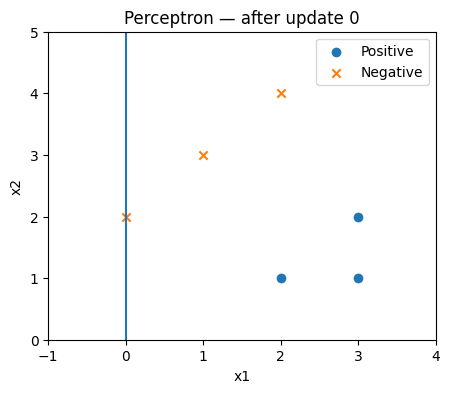

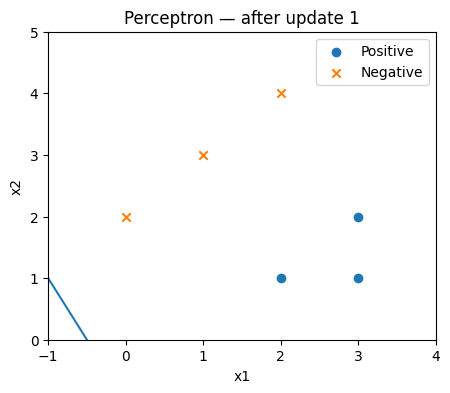

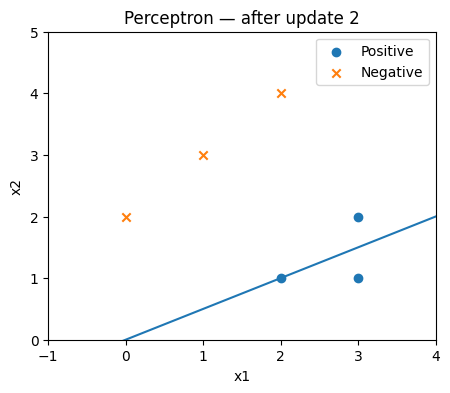

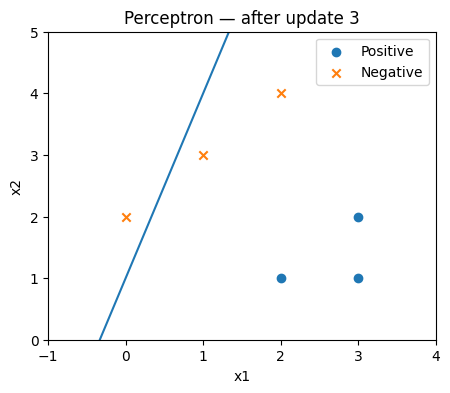

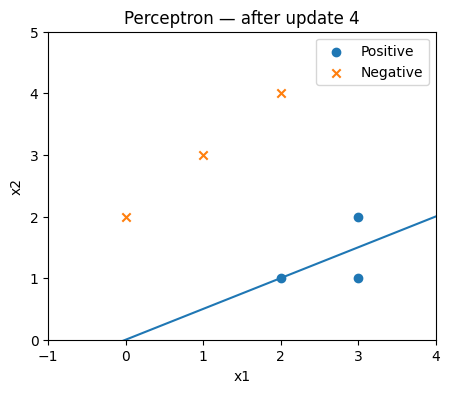

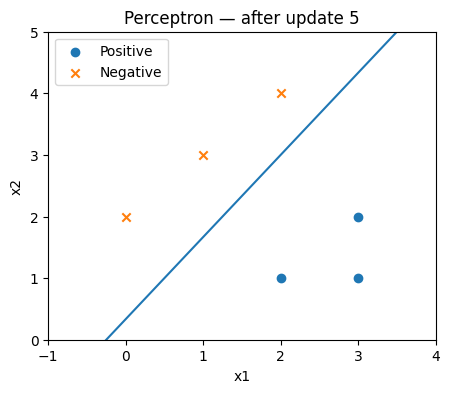

In [3]:
# Perceptron in 2D with bias (visualization after each update)

import numpy as np
import matplotlib.pyplot as plt

# ---------- Toy, separable 2D dataset ----------
# Positive (+1) and Negative (-1). Feel free to replace these points.
pos = np.array([[2,1],
                [3,1],
                [3,2]])
neg = np.array([[1,3],
                [2,4],
                [0,2]])

X = np.vstack([pos, neg])
y = np.hstack([np.ones(len(pos)), -np.ones(len(neg))])

# Augment with bias term: x̃ = [x1, x2, 1]
X_aug = np.hstack([X, np.ones((X.shape[0],1))])

# ---------- Perceptron ----------
def perceptron_train(X_aug, y, lr=1.0, max_epochs=100):
    w = np.zeros(X_aug.shape[1], dtype=float)
    history = [w.copy()]
    for _ in range(max_epochs):
        mistakes = 0
        for xi, yi in zip(X_aug, y):
            if yi * np.dot(w, xi) <= 0:
                w = w + lr * yi * xi
                history.append(w.copy())
                mistakes += 1
        if mistakes == 0:
            break
    return w, history

w_final, w_hist = perceptron_train(X_aug, y, lr=1.0, max_epochs=100)

print("Final weight (with bias):", w_final)
print("Updates:", len(w_hist)-1)

# ---------- Plot after each update ----------
def plot_boundary(ax, w, xlim, ylim):
    # w = [w1, w2, b], decision boundary: w1*x + w2*y + b = 0 -> y = -(w1/w2)x - b/w2
    if abs(w[1]) < 1e-12:
        # vertical line: w1*x + b = 0
        x = -w[2]/(w[0]+1e-12)
        ax.axvline(x)
    else:
        xs = np.linspace(*xlim, 200)
        ys = -(w[0]/w[1]) * xs - (w[2]/w[1])
        ax.plot(xs, ys)

def plot_step(w, step_idx):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(pos[:,0], pos[:,1], label="Positive", marker='o')
    ax.scatter(neg[:,0], neg[:,1], label="Negative", marker='x')
    ax.set_title(f"Perceptron — after update {step_idx}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    xlim = (min(X[:,0])-1, max(X[:,0])+1)
    ylim = (min(X[:,1])-1, max(X[:,1])+1)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot_boundary(ax, w, xlim, ylim)
    ax.legend()
    plt.show()

# Show the boundary after each update (first few if many)
for i, w in enumerate(w_hist):
    plot_step(w, i)  # i=0 is initial w; subsequent i are after updates
